In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import warnings
warnings.filterwarnings('ignore')
pd.options.plotting.backend = "plotly"

import plotly.io as pio
pio.templates.default = "none"

plt.style.use('default')
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (16, 4)
plt.rcParams['figure.dpi'] = 150

In [2]:
df_start1 = pd.read_csv('Test_004618.csv', header=None)[[2, 3]]
df_end1 = pd.read_csv('Test_121229.csv', header=None)[[2, 3]]

df_indices = pd.read_excel('start_end_comparison.xlsx', sheet_name='Group 2', header=None)
df_indices.columns = ['looping_start1', 'looping_start2', 'looping_end1', 'looping_end2']

In [39]:
df_indices.shape

(9, 4)

In [3]:
def get_data(signal_, indices):
    return signal_[indices[0]: indices[1]]

signal_start, signal_end = [], []
for idx, row in df_indices.iterrows():
    signal_start.append(get_data(df_start1[3], indices=row[: 2]))
    signal_end.append(get_data(df_end1[3], indices=row[2: 4]))

### Transform signal to time-frequency to calculate F-stats

In [5]:
import pywt

In [12]:
widths = np.arange(10, 100)
fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(20, 30), sharex='all')

start_wavelet, end_wavelet = [], []

for idx in range(8):
    start_signal, t_start = signal_start[idx].values, np.arange(0, signal_start[idx].shape[0])
    end_signal, t_end = signal_end[idx].values, np.arange(0, signal_end[idx].shape[0])

    cwtmatr_start, freqs_start = pywt.cwt(start_signal, widths, 'morl')
    cwtmatr_end, freqs_end = pywt.cwt(end_signal, widths, 'morl')

    start_wavelet.append(cv2.resize(cwtmatr_start, (500, 100)))
    end_wavelet.append(cv2.resize(cwtmatr_end, (500, 100)))

    ax[idx][0].imshow(cwtmatr_start.astype(np.float32), aspect='auto', extent=[-1, 1, 1, 31],
                      cmap=plt.cm.seismic, vmax=abs(cwtmatr_start).max(), vmin=-abs(cwtmatr_start).max())

    ax[idx][1].imshow(cwtmatr_end.astype(np.float32), aspect='auto', extent=[-1, 1, 1, 31],
                      cmap=plt.cm.seismic, vmax=abs(cwtmatr_end).max(), vmin=-abs(cwtmatr_end).max())


plt.tight_layout()
plt.savefig('result_wavelet')
plt.close()

In [70]:
fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(20, 30), sharex='all')

for idx in range(8):
    start_signal, t_start = signal_start[idx].values, np.arange(0, signal_start[idx].shape[0])
    end_signal, t_end = signal_end[idx].values, np.arange(0, signal_end[idx].shape[0])
    ax[idx][0].plot(start_signal)
    ax[idx][1].plot(end_signal)

plt.tight_layout()
plt.savefig('raw_signals')
plt.close()

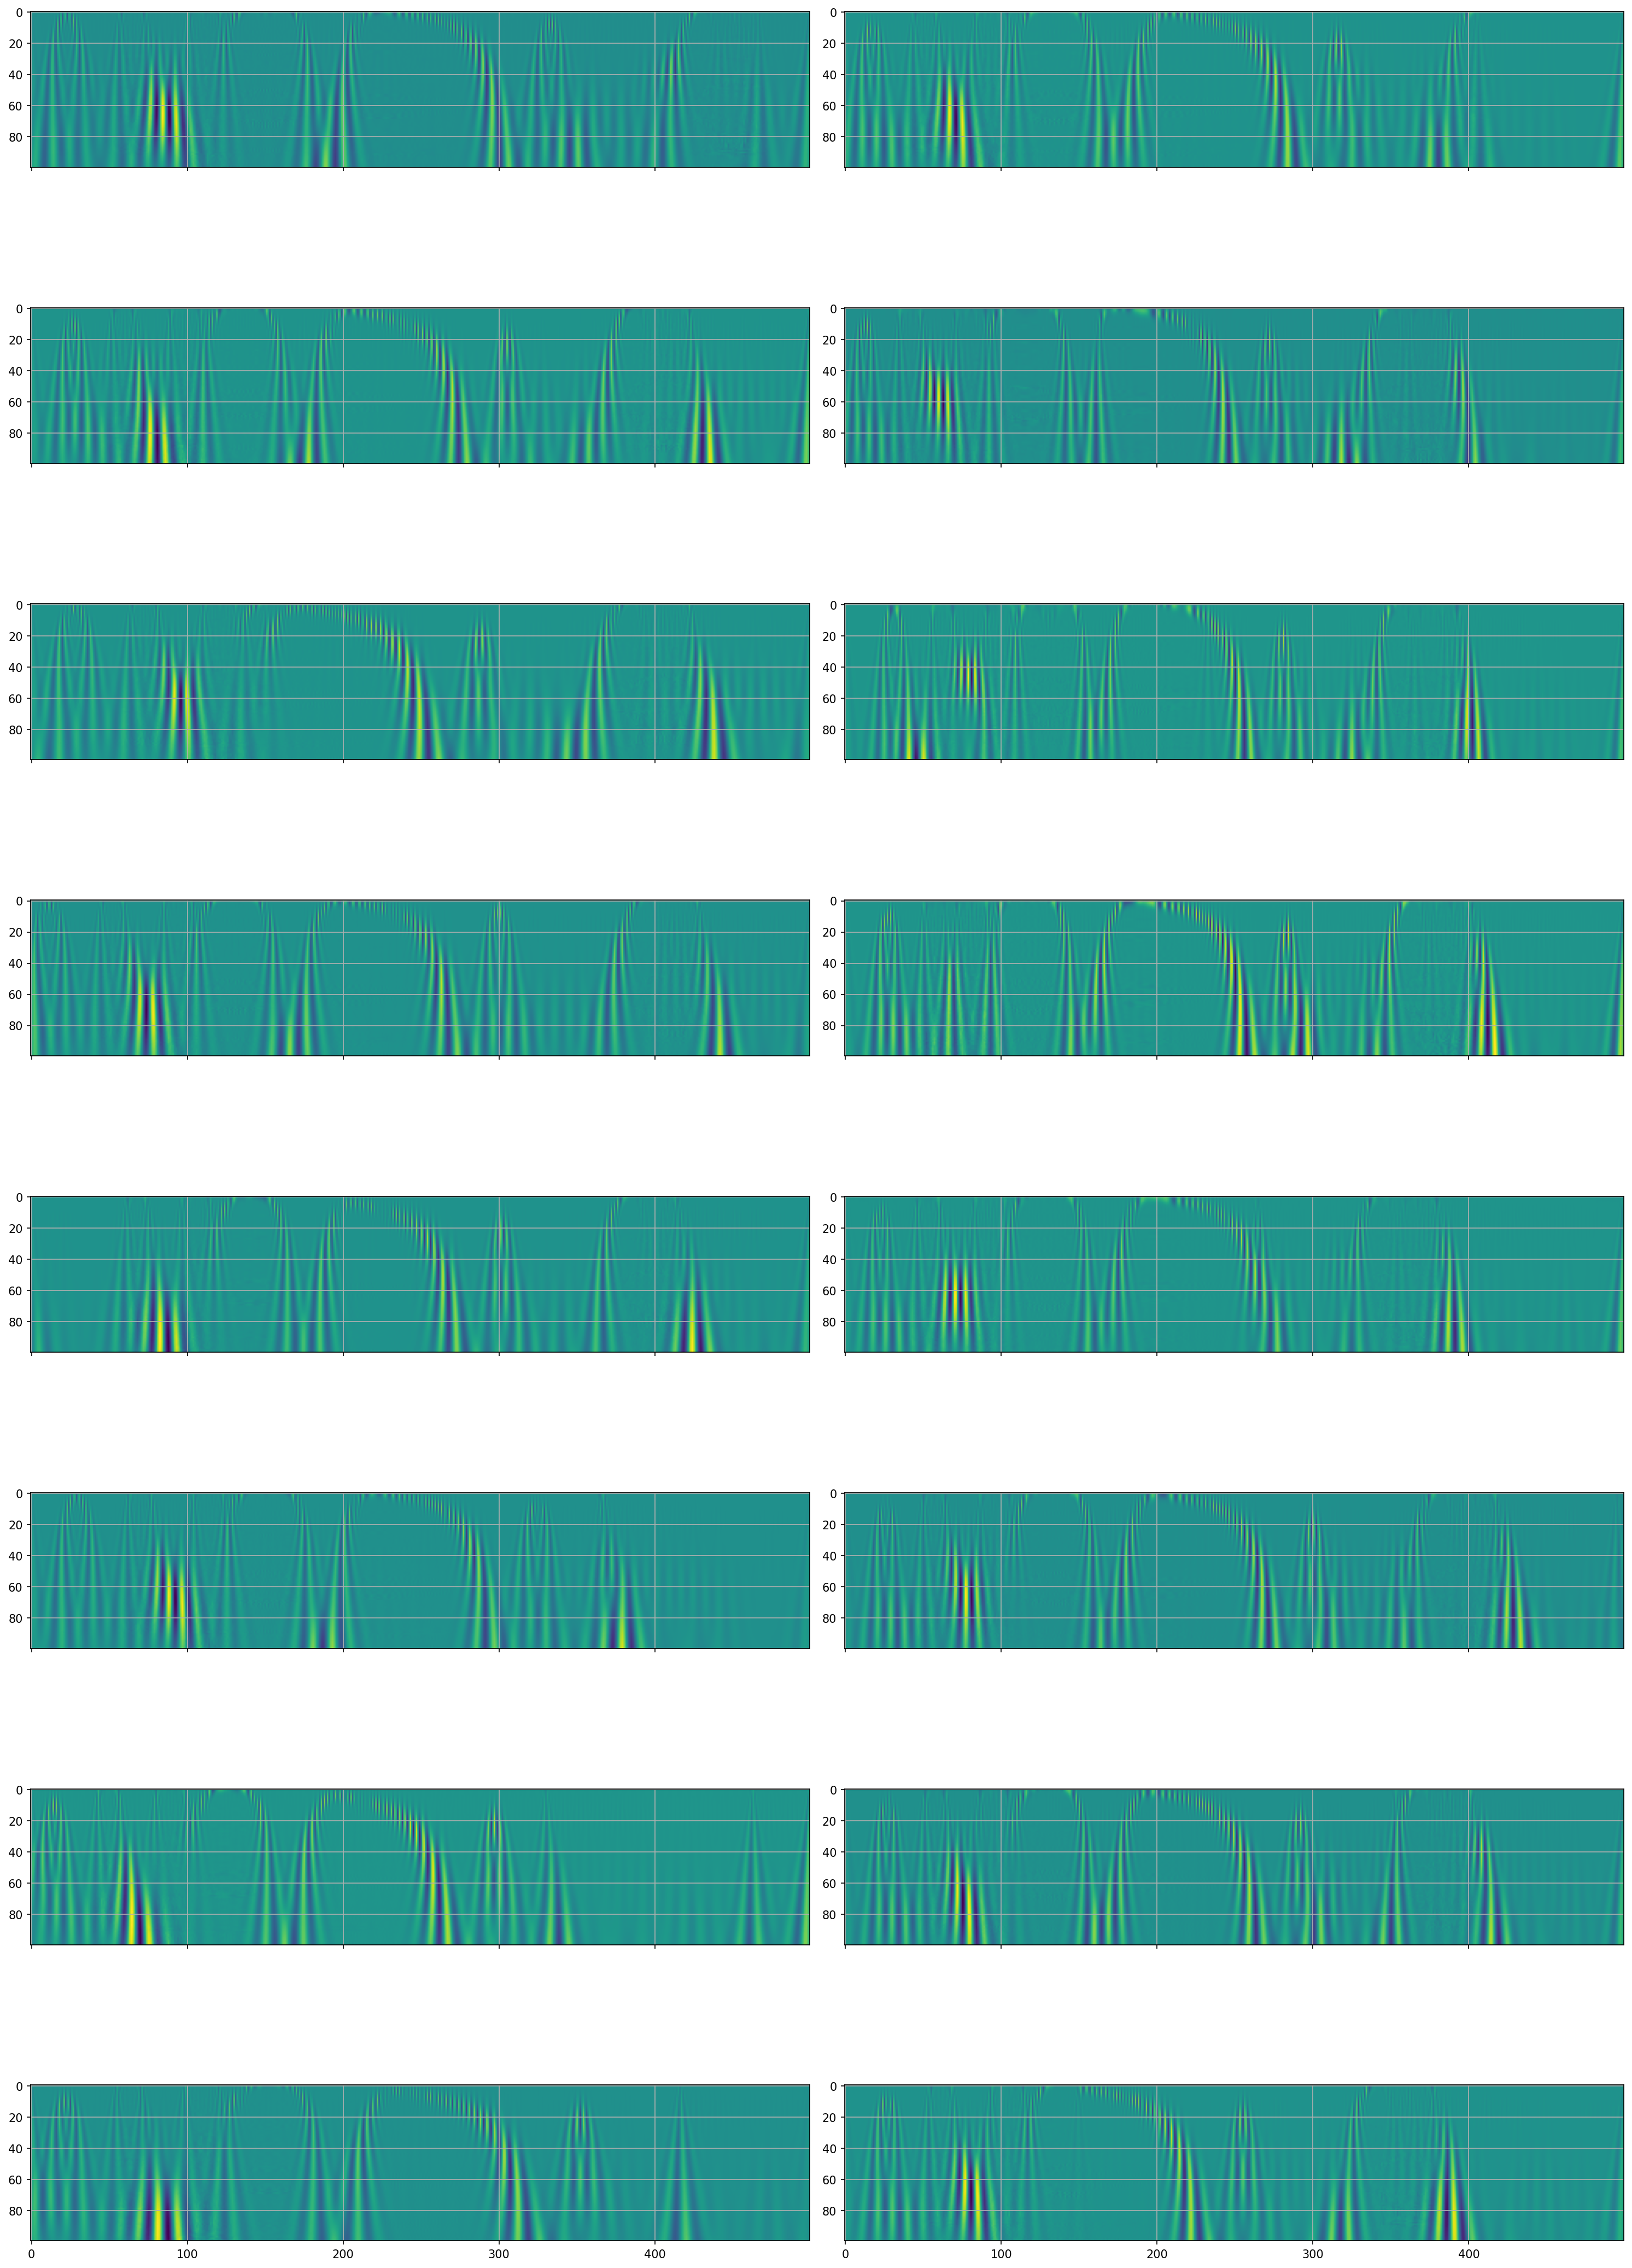

In [13]:
fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(20, 30), sharex='all')
for idx in range(8):
    ax[idx][0].imshow(start_wavelet[idx])
    ax[idx][1].imshow(end_wavelet[idx])

plt.tight_layout()
plt.show()

### Test for F-statistics

In [18]:
def get_mean_samples(group, ii, jj):
    sum_ = 0
    for sample in group:
        sum_ += sample[ii, jj]
    return sum_ / len(group)

def cal_var_between(n_i_, mean_samples_, mean_groups_):
    var = 0
    for i in range(2):
        var += n_i_ * (mean_samples_[i] - mean_groups_) ** 2

    return var

def cal_var_within(n_i_, group, mean_samples_, ii, jj, total_samples_):
    var = 0
    for i in range(2):
        for j in range(n_i_):
            var +=  (group[j][ii, jj] - mean_samples_[i])**2 / (total_samples_ - 2)
    return var

def cal_f_stats(group1, group2, n_i, total_samples):
    """
    Calculate F-statistics

    :param total_samples:
    :param group1:
    :param group2:
    :param n_i: number of samples for ach group
    :return:
    """
    f_matrix = np.zeros(group1[0].shape)
    for ii in range(f_matrix.shape[0]):
        for jj in range(f_matrix.shape[1]):

            mean_samples = [get_mean_samples(group1, ii, jj), get_mean_samples(group2, ii, jj)]
            mean_group = np.mean(mean_samples)

            var_between = cal_var_between(n_i, mean_samples, mean_group)
            var_within = np.sum([cal_var_within(n_i, group1, mean_samples, ii, jj, total_samples),
                                cal_var_within(n_i, group2, mean_samples, ii, jj, total_samples)])

            f_matrix[ii, jj] = var_between / var_within

    return f_matrix

In [25]:
f_matrix = cal_f_stats(group1=start_wavelet[:5], group2=end_wavelet[: 5], n_i=5, total_samples=10)
plt.imshow(f_matrix, cmap=plt.cm.seismic)
plt.colorbar()
plt.title('F-statistics for start and end of time-frequency for the SAME group')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('f_test_same_group.png')
plt.close()

In [26]:
f_matrix = cal_f_stats(group1=start_wavelet[5:], group2=end_wavelet[5:], n_i=3, total_samples=6)
plt.imshow(f_matrix, cmap=plt.cm.seismic)
plt.colorbar()
plt.title('F-statistics for start and end of time-frequency for the DIFFERENT group')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('f_test_diff_group.png')
plt.close()